**The following topics are covered in this tutorial:**


*   Downloading a real-world dataset.
*   Preparing a dataset for training.
*   Training and interpreting decision trees.
*   Training and interpreting random forests.
*   Overfitting, hyperparameter.
*   Preparing a dataset for training.


##**Problem Statement**
This tutorial takes a practical and a coding-focussed approach.

> **QUESTION**: The Rain in Australia dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

> As a data scientist at the Bureau of Metorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

In [114]:
!pip install opendatasets --upgrade --quiet

In [115]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] ='#00000000'

## **Downloading the Data**

The dataset  is available at https://www.kaggle.com/jsphyg/weather-dataset-ratte-package

We'll use the opendatasets library to download the data from Kaggle directly within Jupyter

In [116]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


The dataset is downloaded and extracted to the folder `weather-dataset-rattle-package`.

In [117]:
os.listdir('weather-dataset-rattle-package')

['weatherAUS.csv']

The file `weatherAUS` contains the data. Let's load it to a Pandas dataframe.

In [118]:
raw_df = pd.read_csv('weather-dataset-rattle-package'+'/weatherAUS.csv')


 Each row shows the measurements for a given date at a given location. The last column `RainTomorrow` contains the value to be predicted.

 Let's check the column types of the dataset.

In [119]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Let's drop any rows where the value of the target column `RainTomorrow` is empty.

In [120]:
raw_df.dropna(subset = ['RainToday', 'RainTomorrow'], inplace =True)

>**EXERCISE**: Perform exploratory data analysis on the dataetand study the relationship of other columns with the `RainTomorrow` column.

Let's check thecolumn types of the dataset.

In [121]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140787 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           140787 non-null  object 
 1   Location       140787 non-null  object 
 2   MinTemp        140319 non-null  float64
 3   MaxTemp        140480 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81093 non-null   float64
 6   Sunshine       73982 non-null   float64
 7   WindGustDir    131624 non-null  object 
 8   WindGustSpeed  131682 non-null  float64
 9   WindDir9am     131127 non-null  object 
 10  WindDir3pm     137117 non-null  object 
 11  WindSpeed9am   139732 non-null  float64
 12  WindSpeed3pm   138256 non-null  float64
 13  Humidity9am    139270 non-null  float64
 14  Humidity3pm    137286 non-null  float64
 15  Pressure9am    127044 non-null  float64
 16  Pressure3pm    127018 non-null  float64
 17  Cloud9am       88162 non-null   fl

#**Preparing the Data for Training**

We'll perform the following steps to prepare the dataset for training:


1.   Create a train/test/validation split
2.   Identify input and target columns
3.   Identify numeric and categorical columns.
4.   Impute(fill) missing numeric values
5.   Scale numeric values to the (0,1) range
6.   Encode categorical columns and one-hot vectors






# **Training, Validation and Test Sets**

<Axes: title={'center': 'No. of Rows per Year'}, xlabel='Date', ylabel='count'>

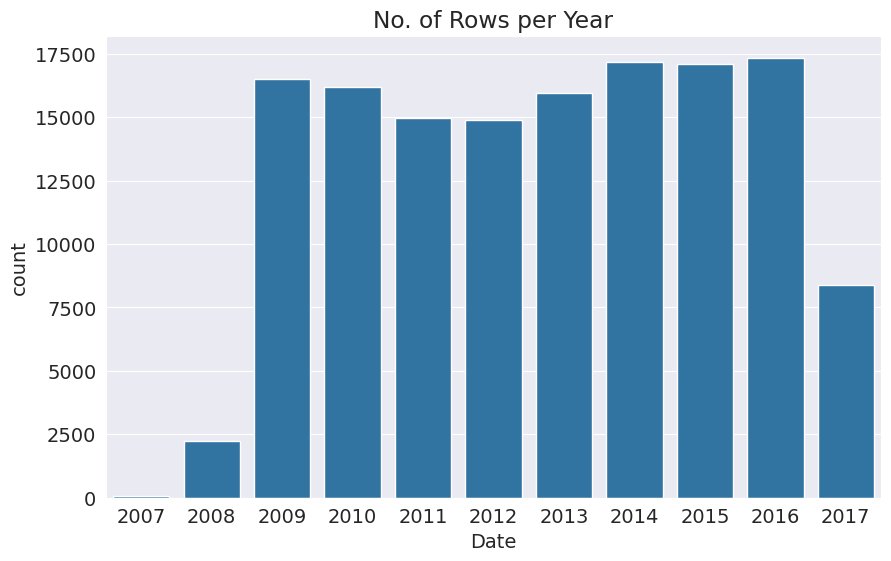

In [122]:
 plt.title('No. of Rows per Year')
 sns.countplot(x=pd.to_datetime(raw_df.Date, dayfirst = True, format='mixed').dt.year)

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on dat from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.

In [123]:
year = pd.to_datetime(raw_df.Date, dayfirst=True, format ='mixed').dt.year
train_df, val_df, test_df = raw_df[year<2015],raw_df[year==2015],raw_df[year>2015]

>**EXERCISE**: Scrap climate data for recent years (2017 to 2021) from http://www.born.gov.au/climate/data and try training with the enlarged dataset.

# **Input and target columns**
Let's identify the inputs and target columns , `train_targets` is a pandas series.

In [124]:
input_cols = list(raw_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()


Let's also identify the numeric and categorical columns.

In [125]:
numeric_cols = train_inputs.select_dtypes( include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include = 'object').columns.tolist()

In [126]:
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [127]:
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

> **EXERCISE**: Study how various columns are correlated with the target and select just a subset of the columns, instead of all of them. Observe how it affects the results.

# **Imputing missing numeric values**


In [128]:
train_inputs[numeric_cols].isnull().sum().sort_values(ascending = False)

Sunshine         40046
Evaporation      36331
Cloud3pm         36022
Cloud9am         34988
Pressure3pm       9131
Pressure9am       9112
WindGustSpeed     6828
Humidity3pm       1116
WindSpeed3pm      1069
Humidity9am       1052
WindSpeed9am       874
Temp3pm            596
Temp9am            574
MinTemp            314
MaxTemp            187
Rainfall             0
dtype: int64

In [129]:
from sklearn.impute import SimpleImputer

In [130]:
imputer = SimpleImputer(strategy  ='mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols]=imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]=imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]=imputer.transform(test_inputs[numeric_cols])

>**EXERCISE**:Try a different imputation strategy and see how it affects the results.

# **Scaling Categorical features**

In [131]:
 val_inputs.describe().loc[['min','max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,-8.2,-3.2,0.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,988.1,982.2,0.0,0.0,-6.2,-4.0
max,31.9,45.4,247.2,70.4,14.5,135.0,87.0,74.0,100.0,100.0,1039.3,1037.3,8.0,8.0,37.5,42.8


In [132]:
from sklearn.preprocessing import MinMaxScaler

In [133]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols]=scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]=scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols]=scaler.transform(test_inputs[numeric_cols])

In [134]:
val_inputs[numeric_cols].describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


>**EXERCISE**: Try a different scaling strategy and observe how it affects the results.

>

# **Encoding Categorical Data**

In [135]:
##!pip list
##!pip install scikit-learn==0.1.3

In [136]:
train_inputs[categorical_cols]=train_inputs[categorical_cols].fillna('unknown')
val_inputs[categorical_cols]=val_inputs[categorical_cols].fillna('unknown')
test_inputs[categorical_cols]=test_inputs[categorical_cols].fillna('unknown')

In [137]:
from sklearn.preprocessing import OneHotEncoder

In [138]:
encoder  =OneHotEncoder(sparse_output =False, handle_unknown = 'ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols]= encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols]= encoder.transform(test_inputs[categorical_cols])

#train_encoded = pd.DataFrame(encoder.transform(train_inputs[categorical_cols]), columns=encoded_cols, index=train_inputs.index)
#val_encoded =pd.DataFrame(encoder.transform(val_inputs[categorical_cols]), columns=encoded_cols, index=val_inputs.index)
#test_encoded = pd.DataFrame(encoder.transform(test_inputs[categorical_cols]), columns=encoded_cols, index=test_inputs.index)



<ipython-input-138-d72110ba1aef>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
<ipython-input-138-d72110ba1aef>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
<ipython-input-138-d72110ba1aef>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

>**EXRECISE**:Try a different encoding strategy and observe how it affetcts the results.

As a final step, let's drop the textual columns, so that we're left with just numeric data.

In [139]:
x_train  = train_inputs[numeric_cols+encoded_cols]
x_val  =val_inputs[numeric_cols+encoded_cols]
x_test  = test_inputs[numeric_cols+encoded_cols]

#x_train = pd.concat([train_inputs[numeric_cols],train_encoded ],axis=1)
#x_val = pd.concat([val_inputs[numeric_cols],val_encoded ],axis=1)
#x_test = pd.concat([test_inputs[numeric_cols],test_encoded ],axis=1)


# **Training and Visualizing Decision Trees**

A decision tree represents a hierachical series of binary decisions.  

A decsion tree in Machine Learning works the same way we make decisions, except that we let the computer figure out the optimal structure and hierachy of decisions, instead of coming with criteria manually.

#**Training**

We use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [140]:
from sklearn.tree import DecisionTreeClassifier

In [141]:
model = DecisionTreeClassifier(random_state=42)

In [142]:
%%time
model.fit(x_train, train_targets)

CPU times: user 4.92 s, sys: 23.9 ms, total: 4.94 s
Wall time: 8.23 s


DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

**Evaluation**

Let's evaluate the decision tree using the accuracy score

In [143]:
x_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.516509,0.523629,0.001617,0.037741,0.526244,0.294574,0.153846,0.275862,0.71,0.22,0.449587,0.4800,0.888889,0.499917,0.508439,0.522073,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.565217,0.000000,0.037741,0.526244,0.294574,0.030769,0.252874,0.44,0.25,0.497521,0.4912,0.492351,0.499917,0.514768,0.570058,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.576560,0.000000,0.037741,0.526244,0.310078,0.146154,0.298851,0.38,0.30,0.447934,0.5056,0.492351,0.222222,0.594937,0.548944,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.417453,0.620038,0.000000,0.037741,0.526244,0.139535,0.084615,0.103448,0.45,0.16,0.613223,0.5712,0.492351,0.499917,0.533755,0.612284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [144]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

In [145]:
train_preds=model.predict(x_train)

In [146]:
pd.value_counts(train_preds)

No     76192
Yes    21796
Name: count, dtype: int64

In [147]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [148]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [149]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

The decision tree  also returns probabilities for each prediction.

In [150]:
train_probs = model.predict_proba(x_train)

In [151]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions

In [152]:
accuracy_score(train_targets, train_preds)

0.9999795893374699

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too.

We can make predictions and compute accuracy in one step using `model.score`

In [153]:
model.score(x_val, val_targets)

0.7912107203464217

Although the training accuracy is `100%`, the accuracy on the validation set is just about `79%` which is marginally better than always predicting `"No"`.

In [154]:
val_targets.value_counts()/len(val_targets)

RainTomorrow
No     0.790626
Yes    0.209374
Name: count, dtype: float64

It appears that the model has learned the training examples perfect and doesn,t generalize well to previously unseen examples. This phenomenon is called **overfitting** and reducing overfitting is one of the most important parts of any Machine Learning project.

#**Visualization**

We can visualize the decision tree learned from the training data.

In [155]:
from sklearn.tree import plot_tree , export_text

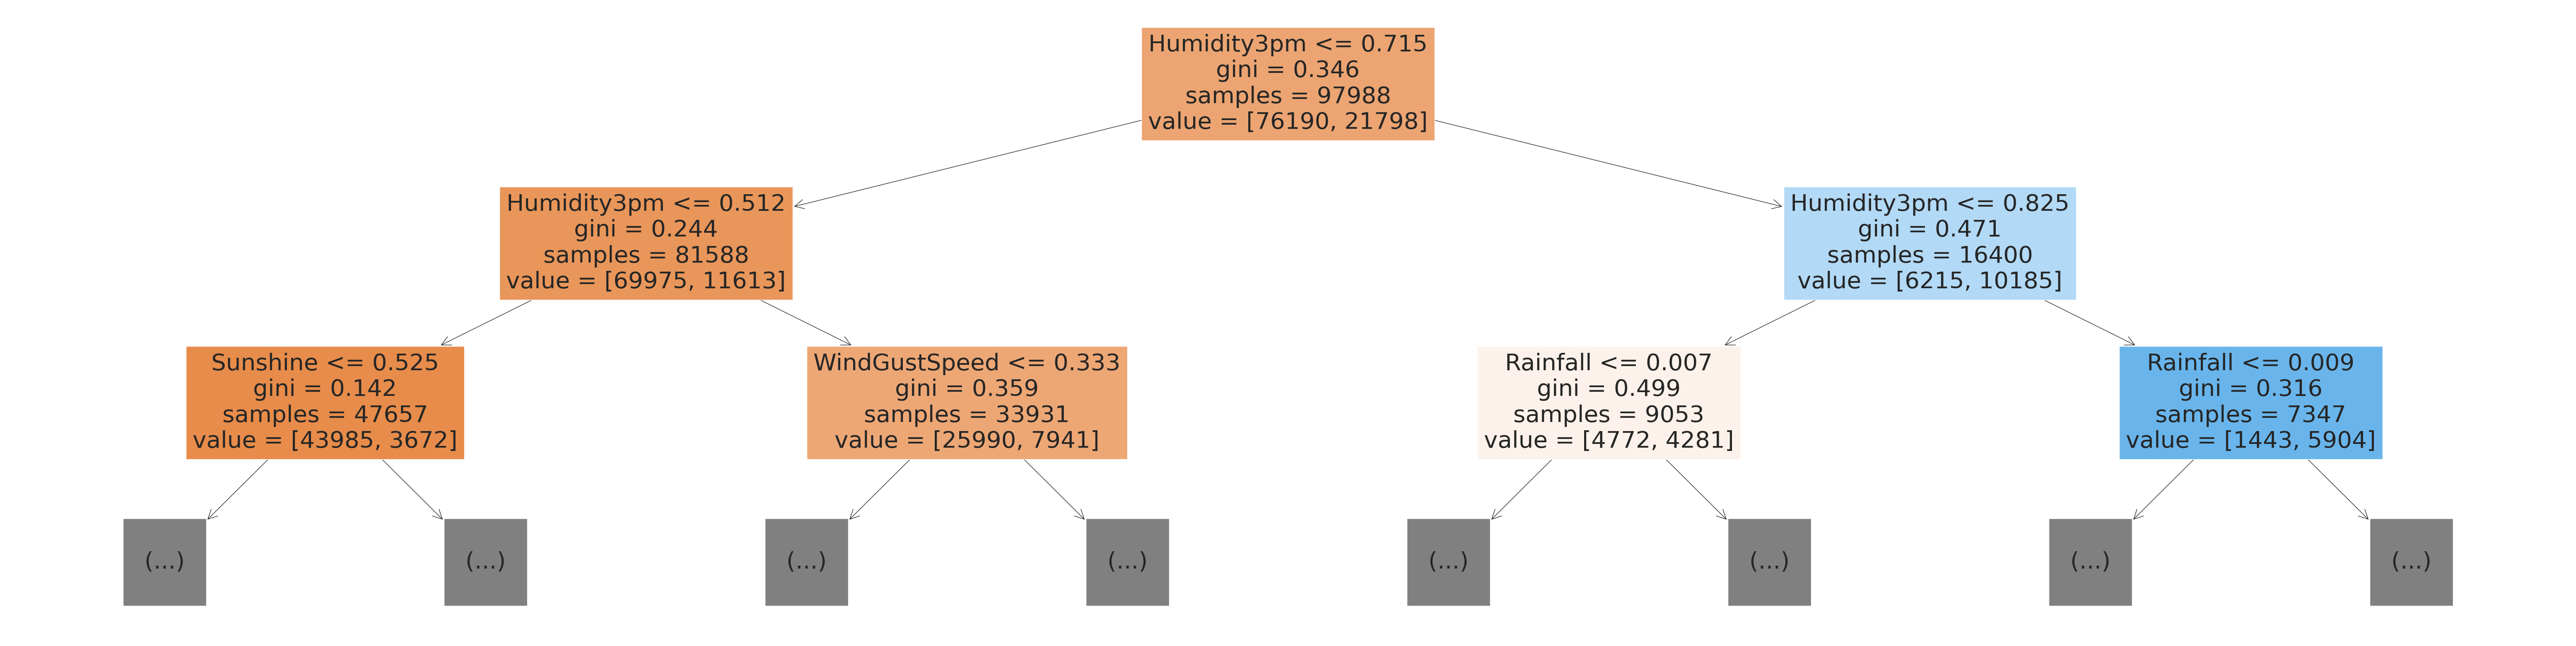

In [156]:
plt.figure(figsize = (80,20))
plot_tree(model, feature_names=x_train.columns, max_depth =2, filled=True);

Can you see hw the model classifiers a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in `"Yes"`, `"No"`. Do you see how a decision tree differs from a logistic regression model?

**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

**Gini Index**

The model evaluates all possible splits across all possible columns and pick the best one. Then, it recursively performs an optimal split for thr two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

Let's check the depth of the tree that was created.

In [157]:
model.tree_.max_depth

49

We can also display the tree as text, which can be easier to follow for deeper trees.

In [158]:
tree_text = export_text(model, max_depth = 10, feature_names =list(x_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- WindGustDir_N <= 0.50
|   |   |   |   |   |   |   |--- WindSpeed9am <= 0.32
|   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.06
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.06
|   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |   |   |   |   |   |--- Temp9am <= 0.65
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Temp9am >  0.65
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.44
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindSpeed9am >  0.32
|   |   |   |   |   |   |   | 

>**EXERCISE**: Based on the above discussion, can you explain why the training accuracy is `100%` whereas the validation accuracy is lower?

# **Feature Importance**
Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.


In [159]:
x_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW',
       'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan',
       'RainToday_No', 'RainToday_Yes'],
      dtype='object', length=118)

In [160]:
model.feature_importances_

array([3.79035131e-02, 3.00803768e-02, 4.39119927e-02, 2.32076920e-02,
       4.83670092e-02, 6.06130339e-02, 2.70861397e-02, 2.98377960e-02,
       3.80323862e-02, 2.78565666e-01, 3.74407820e-02, 6.25535525e-02,
       1.48552575e-02, 1.66775904e-02, 3.64808512e-02, 3.31353397e-02,
       1.93233126e-03, 2.12143418e-03, 1.21957995e-03, 7.09509946e-04,
       1.66232115e-03, 1.17763312e-03, 1.11226744e-03, 1.74207112e-03,
       7.79715073e-04, 1.41076514e-03, 8.09613477e-04, 2.22109172e-03,
       1.47953367e-03, 5.33596391e-04, 9.45431229e-04, 1.61648361e-03,
       6.16690435e-05, 1.31386688e-03, 8.96453343e-04, 1.55952275e-03,
       7.51175379e-04, 1.02590872e-03, 1.35951758e-03, 1.51705658e-03,
       6.21950615e-04, 8.01638384e-04, 1.25335513e-03, 1.48220472e-03,
       1.21673639e-03, 9.95148823e-04, 5.62581113e-04, 1.22346951e-03,
       1.45317564e-03, 2.07638712e-03, 1.15084567e-03, 1.88758571e-03,
       1.07574268e-03, 2.02997155e-03, 1.27849935e-03, 3.85530179e-04,
      

In [161]:
importance_df = pd.DataFrame({
    'feature':x_train.columns,
    'importance':model.feature_importances_
    }).sort_values('importance', ascending  =False)

In [162]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.278566
11,Pressure3pm,0.062554
5,WindGustSpeed,0.060613
4,Sunshine,0.048367
2,Rainfall,0.043912
8,Humidity9am,0.038032
0,MinTemp,0.037904
10,Pressure9am,0.037441
14,Temp9am,0.036481
15,Temp3pm,0.033135


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

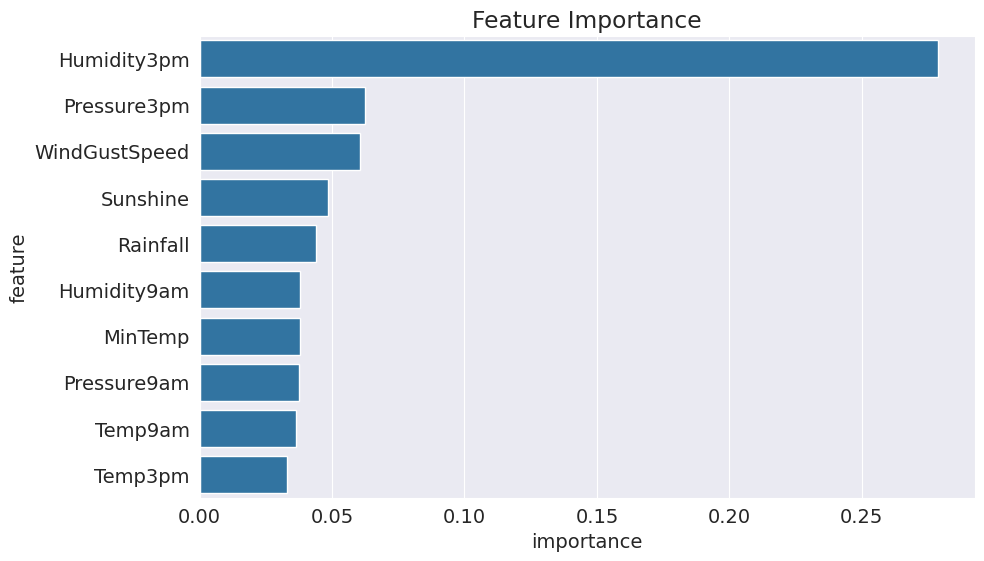

In [163]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10),x='importance', y='feature')

#**Hyperparameter Tuning and Overfitting**

The decision classifier memorized all training examples leading to a 100% training accuracy, while the validation accuracy was marginally better than a dumb baseline model. This phenomenon is called overfitting. The process of reducing **overfitting** is known as **regularization**.
Overfitting means doing very well in the training data and doing poorly in the validation data.

Regularization tries to increase validation accuracy or get it closer to training accuracy.


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [164]:
?DecisionTreeClassifier

These arguments are called **hyperparameters** because they must be configured manually (as opposed to the parameters within the model which are learned from the data).

Any thing that the model learns like the root node and best split are called **parameters**.
Let's explore acouple of hyperparameters:


*   `max_depth`
*   `max_leaf_nodes`



#`max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better **generalization**.

In [165]:
model.tree_.max_depth

49

In [166]:
model = DecisionTreeClassifier(max_depth = 3, random_state = 42)

In [167]:
model.fit(x_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [168]:
model.score(x_train, train_targets)

0.8315916234640977

In [169]:
model.score(x_val, val_targets)

0.8348060155655685

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

The model now performs better in the validation set than it did before. The model is picking up general trends and not learning/memorizing specific training examples.

In [170]:
model.classes_

array(['No', 'Yes'], dtype=object)

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.346\nsamples = 97988\nvalue = [76190, 21798]\nclass = No'),
 Text(0.25, 0.625, 'Humidity3pm <= 0.512\ngini = 0.244\nsamples = 81588\nvalue = [69975, 11613]\nclass = No'),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.142\nsamples = 47657\nvalue = [43985, 3672]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.335\nsamples = 6010\nvalue = [4731, 1279]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.108\nsamples = 41647\nvalue = [39254, 2393]\nclass = No'),
 Text(0.375, 0.375, 'WindGustSpeed <= 0.333\ngini = 0.359\nsamples = 33931\nvalue = [25990, 7941]\nclass = No'),
 Text(0.3125, 0.125, 'gini = 0.304\nsamples = 27841\nvalue = [22637, 5204]\nclass = No'),
 Text(0.4375, 0.125, 'gini = 0.495\nsamples = 6090\nvalue = [3353, 2737]\nclass = No'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.471\nsamples = 16400\nvalue = [6215, 10185]\nclass = Yes'),
 Text(0.625, 0.375, 'Rainfall <= 0.007\ngini = 0.499\nsamples = 9053\nvalue = [4772, 4281]\

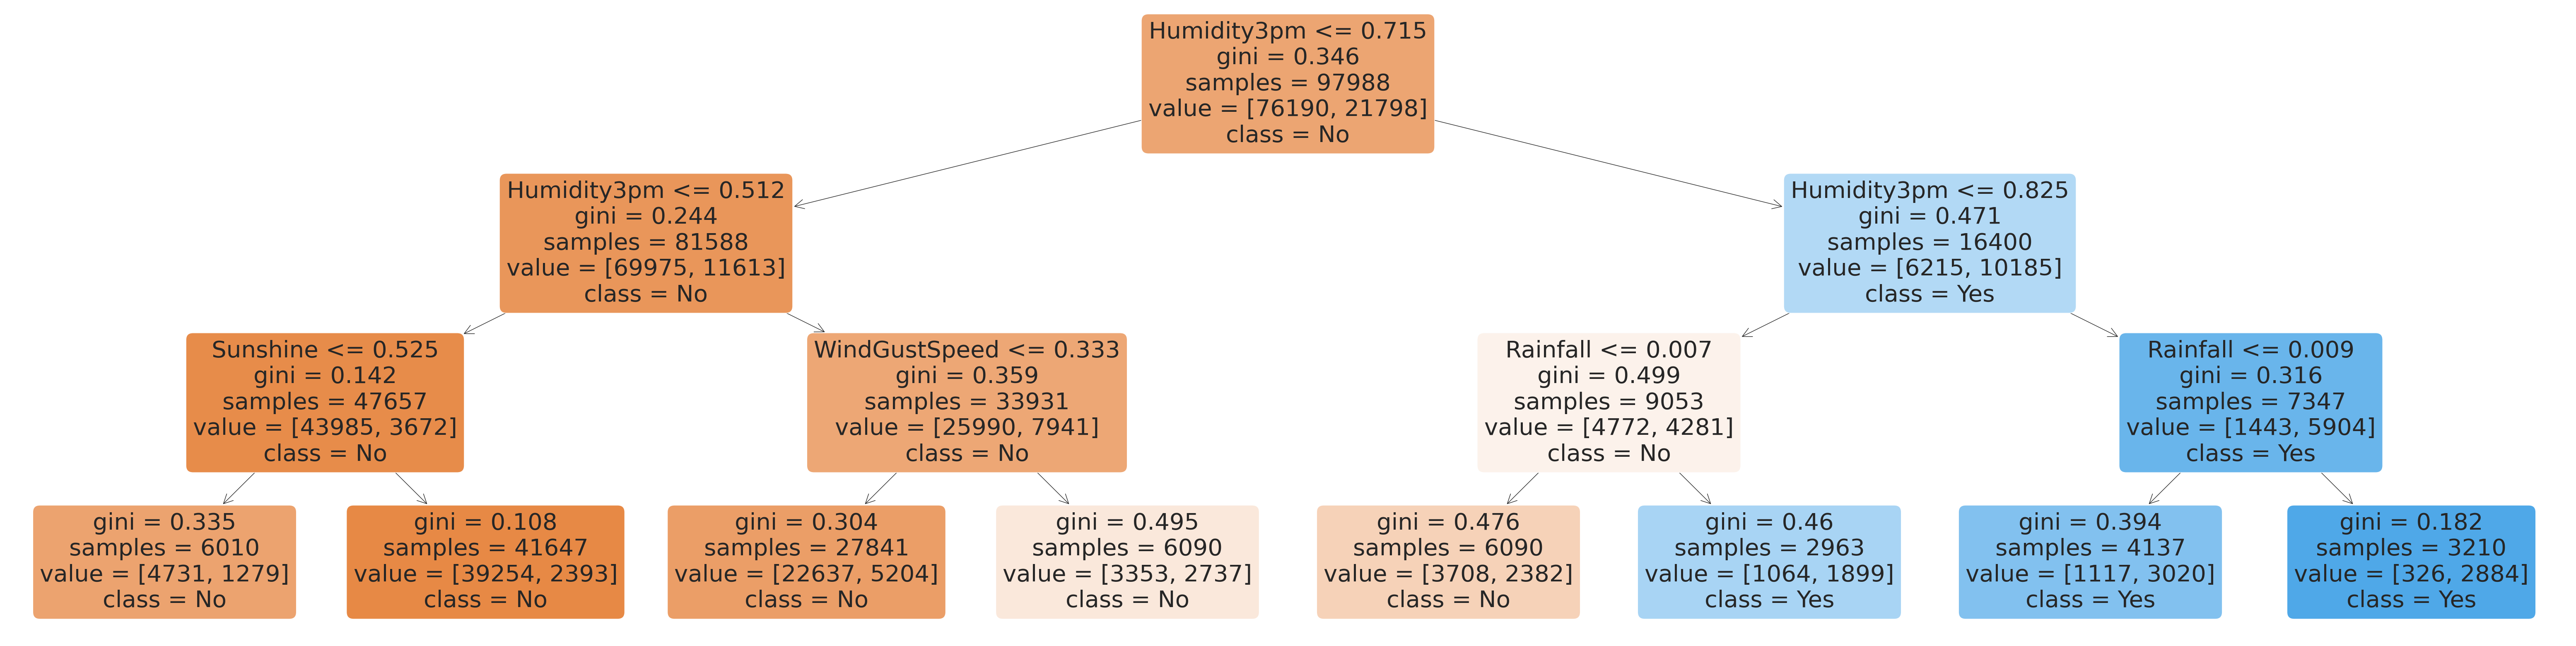

In [171]:
plt.figure(figsize = (80,20))
plot_tree(model, feature_names = x_train.columns,filled = True ,rounded=True, class_names = model.classes_)

>**EXERCISE:** Study the decision tree diagram carefully and understand what each of the terms `gini`, `samples`, `value` and `class` mean.  

In [172]:
print(export_text(model, feature_names = list(x_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.53
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.

In [173]:
def max_depth_error(md):
  model = DecisionTreeClassifier(max_depth=md, random_state=42)
  model.fit(x_train, train_targets)
  train_error = 1-model.score(x_train, train_targets)
  val_error = 1-model.score(x_val,val_targets)
  return {'Max Depth':md, 'Training Error':train_error, 'Validation Error':val_error}

In [174]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])

CPU times: user 57.9 s, sys: 202 ms, total: 58.1 s
Wall time: 1min 14s


In [175]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155890
6,7,0.149059,0.154661
7,8,0.144814,0.154193
8,9,0.139435,0.154485
9,10,0.131812,0.154953


As  you increase the max depths  the training error decreases until the model memorizes the entire training data. The validation error decreases upto a certain point then starts inccreasing.

As the max_depth increases, both the training and validation error decreases and the model becomes more powerful. max_depth helps to adds model complexity/power to the model. Once the model capacity get's large, it focusses on memorizing the data and stops **generalizing the data, a scenario known as overfitting**.





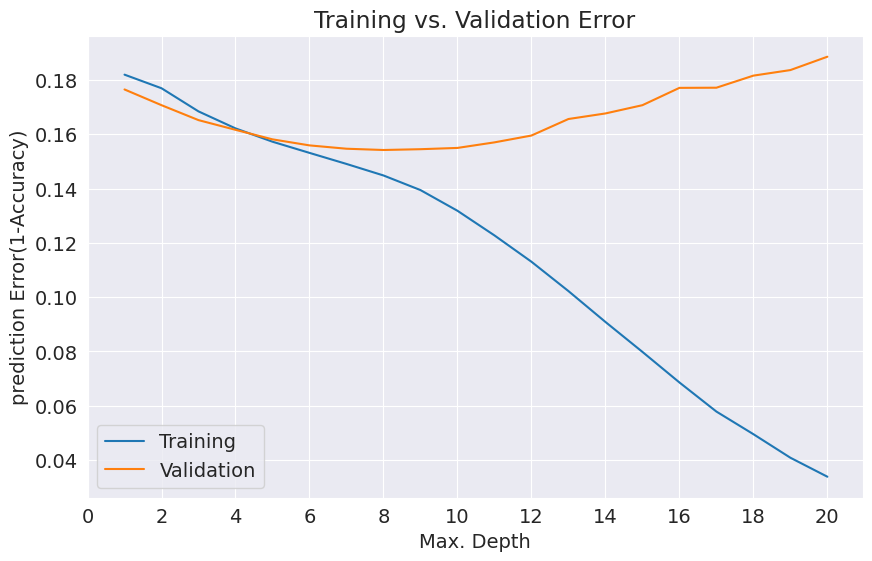

In [176]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21,2))
plt.xlabel('Max. Depth')
plt.ylabel('prediction Error(1-Accuracy)')
plt.legend(['Training','Validation'])

This is a common pattern in all of Machine Learning algorithms:
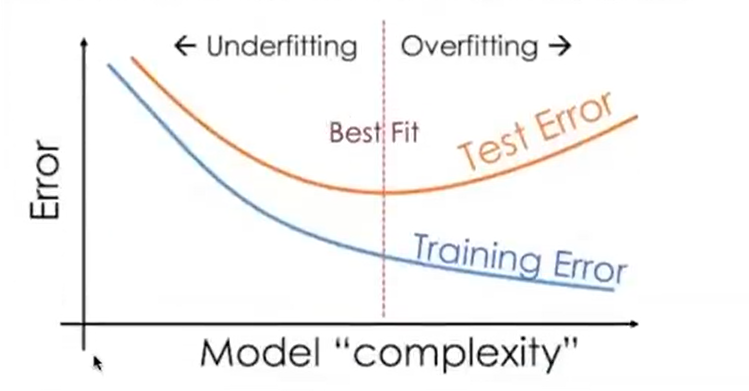


As you increase the complexity/size/ power/capacity of the model you notice the training and the validation error will go down up to a certain point because the model has more capacityso it can learn more and it can cpature information about the inputs and the targets and how they are related. After a certain point it will start memorizing the training examples and that's the point where the test/validation error starts to increase and the training error starts going down. **It is at this point that you stop training**.

Pick the complexity of the model at the point where the validation loss is about to increase.

You'll often need to tune hyperparameters carefully to find the optimal fit.

You regularize a decision tree to reduce overfitting by tuning(changing) some hyperparameters.

In [177]:
model = DecisionTreeClassifier(max_depth = 7, random_state = 42).fit(x_train, train_targets)
model.score(x_train, train_targets), model.score(x_val, val_targets)


(0.8509409315426378, 0.8453391070279127)

#`max_leaf_nodes`
Another way to control the **size of complexity** of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths.

The decision tree doesn't go layer by layer but analyze  all the leaf nodes to determine which is the best split to make based on the one one with the lowest gini coefficient. It looks at all the leaf nodes and it figures out which is the best leaf node to split at the moment.



In [178]:
model = DecisionTreeClassifier(max_leaf_nodes = 128, random_state = 42)

In [179]:
model.fit(x_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [180]:
model.score(x_train, train_targets)

0.852696248520227

In [181]:
model.score(x_val, val_targets)

0.8471531394464276

In [182]:
model.tree_.max_depth

11

Notice that the model was able to achieve a greater depth of 11 for certain paths while keeping other paths shorter.

This means the tree goes to a depth of 11 but certain parts may be shorter i.e. 3 or 4  levels deep.


In [183]:
model_text = export_text(model, feature_names = list(x_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.24
|   |   |   |   |   |   |--- Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  0.44
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindGustSpeed >  0.23

>**EXERCISE:** Find a combination of `max_depth` and `max_leaf_nodes` that results in the highest validation accuracy.

>**EXERCISE:** Explore and experiment with other arguments of `DecisionTree'.

>**EXERCISE:** A more advanced technique (but less comnmonly used  technique) for reducing overfitting in decision trees is known as cost-complexity pruning. Implement cost complexity pruning. Do you see any improvement in the valiadation accuracy?

# **Training a Random Forest**

While tuning the hyperparameter of a single decision tree may lead to some improvements, a more effectve strategy is to combine the results of several decision trees trained with slightly different parameters. This is called random forest model.

The key idea is that each decision tree will make different kinds of errors, and upon averaging many of their errors will cancel out. This is known as **wisdom of the crowd**.

A forest is a collection of trees and random forest because there is randomization involved in how the forest is created. If you create a forest with the exact same dataset, then each decision tree will be identical, so we use randomization to ensure that all the trees in the forest are slightly different to each other.
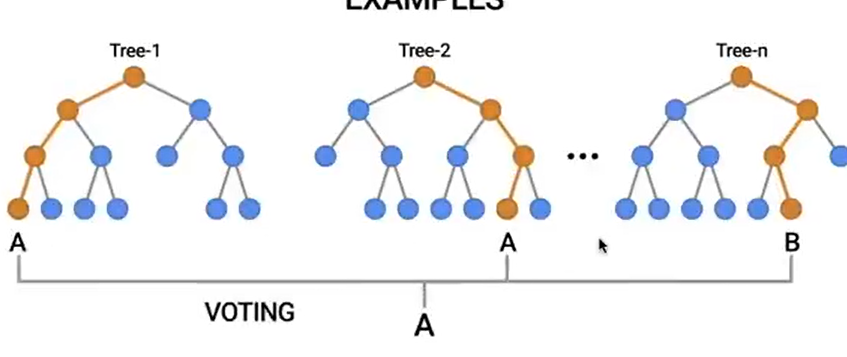

A random forest takes the result of multiple decision trees trained independently and then combines them.

For classifiers, get the output of these n trees and then vote which class is the most commonly occuring class among the ntrees and you return that as the output of the Random Forest. If regression combine by averaging as the output.

We'll use the `RandomForestClassifier` class from from `sklearn.ensemble`.

In [184]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
%%time
model = RandomForestClassifier(n_jobs = -1, random_state = 42)

CPU times: user 68 µs, sys: 2 µs, total: 70 µs
Wall time: 74.6 µs


`n_jobs` allows the random forest to use multiple parallel workers to train decision trees, and `random_state = 42` ensures that we get the same results for each execution.

The reason for passing a `random_state = 42` is that each time I to fit the model I get the exact results.

In [186]:
%%time
model.fit(x_train, train_targets)

CPU times: user 39.9 s, sys: 255 ms, total: 40.2 s
Wall time: 36.4 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [187]:
model.score(x_train, train_targets)

0.9999795893374699

In [188]:
model.score(x_val, val_targets)

0.8563403358885833

The training accuracy is almost 100%, but this time the validation accuracy is much better. It is better than the  best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called `ensembling`. It works because most errors of individual models cancel out on averaging.

Take 30% of the data, train one decision tree on it, another 30% sample of the data, trained another decision tree on it and another 40% of the data trained 1 decision tree on it. Each of the decision trees are imperfect.

If you average all the decision boundaries it is more accurate than the individual decision boundaries

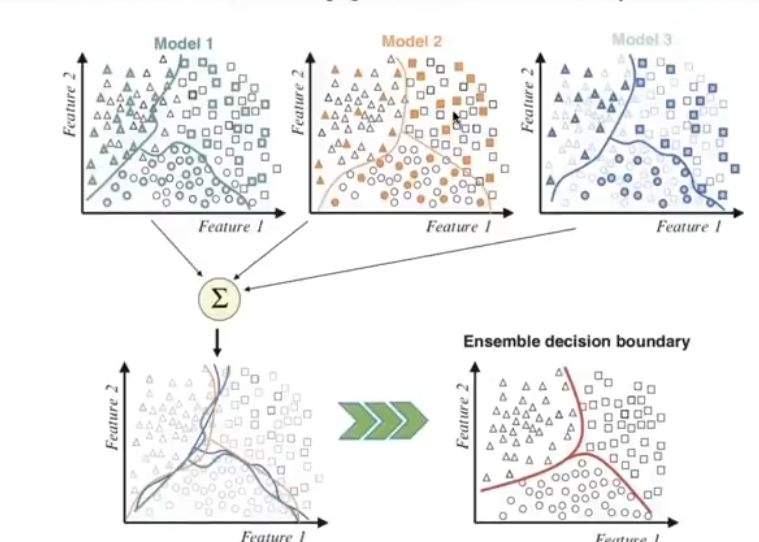

We can also look at the probabilities of the predictions. The probability of a class is the fraction of trees which predicted the given class.

In [189]:
train_probs = model.predict_proba(x_train)
train_probs

array([[0.98, 0.02],
       [0.99, 0.01],
       [0.99, 0.01],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.94, 0.06]])

The probability of a class i.e. the probability of a class No for the first example is the fraction of those trees which predicted the given class No.

Among all the trees that were predicted 98% predicted No for the first example in X_train and only 2% predicted Yes.

In [190]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

We an access individual decision trees using `model.estimators_`

In [191]:
len(model.estimators_)

100

In [192]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

[Text(0.5, 0.875, 'Sunshine <= 0.403\ngini = 0.344\nsamples = 61960\nvalue = [76344, 21644]'),
 Text(0.25, 0.625, 'Location_Cairns <= 0.5\ngini = 0.499\nsamples = 11206\nvalue = [9273, 8335]'),
 Text(0.125, 0.375, 'Rainfall <= 0.007\ngini = 0.498\nsamples = 10799\nvalue = [9032, 7934]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Rainfall <= 0.002\ngini = 0.469\nsamples = 407\nvalue = [241, 401]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Sunshine <= 0.617\ngini = 0.276\nsamples = 50754\nvalue = [67071, 13309]'),
 Text(0.625, 0.375, 'WindGustDir_NNW <= 0.5\ngini = 0.345\nsamples = 34180\nvalue = [42161, 11975]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'WindDir3pm_NW <= 0.5\ngini = 0.096\nsamples = 16574\nvalue = [24910, 1334]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

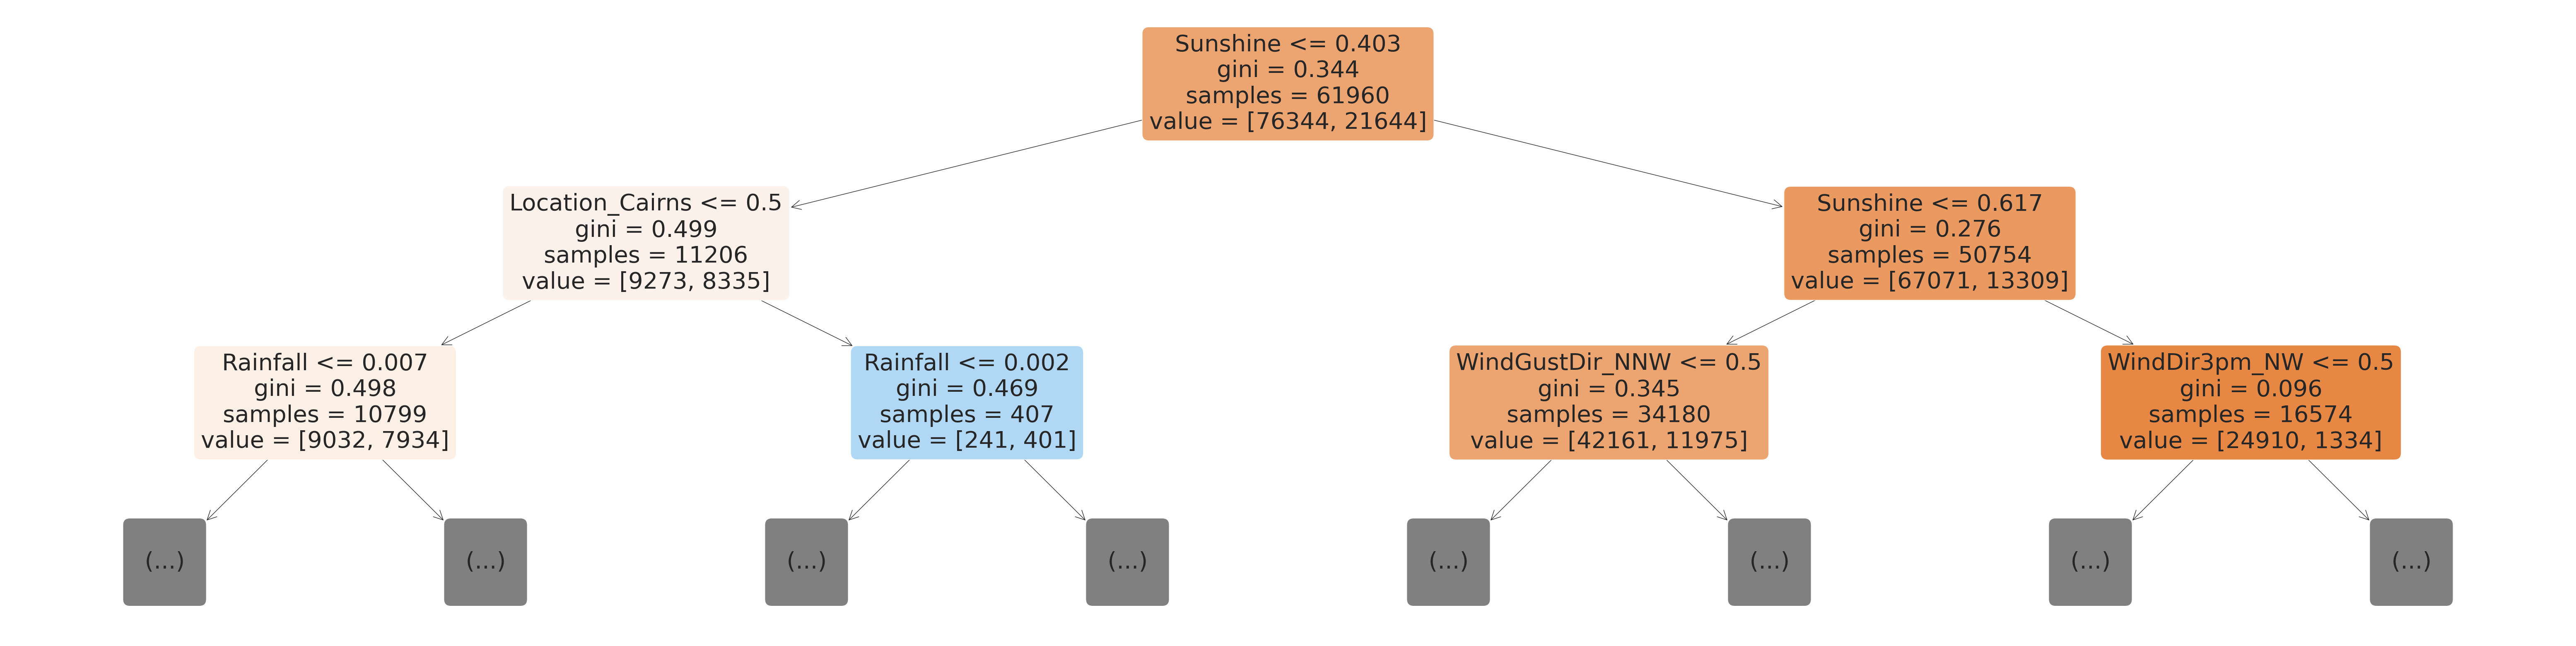

In [193]:
plt.figure(figsize = (80,20))
plot_tree(model.estimators_[0], max_depth = 2, feature_names  =x_train.columns, filled =True, rounded = True)

[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\ngini = 0.348\nsamples = 61980\nvalue = [76040, 21948]'),
 Text(0.25, 0.625, 'Humidity9am <= 0.695\ngini = 0.259\nsamples = 48100\nvalue = [64388, 11594]'),
 Text(0.125, 0.375, 'WindGustSpeed <= 0.38\ngini = 0.197\nsamples = 28238\nvalue = [39743, 4946]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.795\ngini = 0.335\nsamples = 19862\nvalue = [24645, 6648]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Cloud9am <= 0.389\ngini = 0.498\nsamples = 13880\nvalue = [11652, 10354]'),
 Text(0.625, 0.375, 'Cloud9am <= 0.167\ngini = 0.331\nsamples = 1644\nvalue = [2061, 545]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Location_Tuggeranong <= 0.5\ngini = 0.5\nsamples = 12236\nvalue = [9591, 9809]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

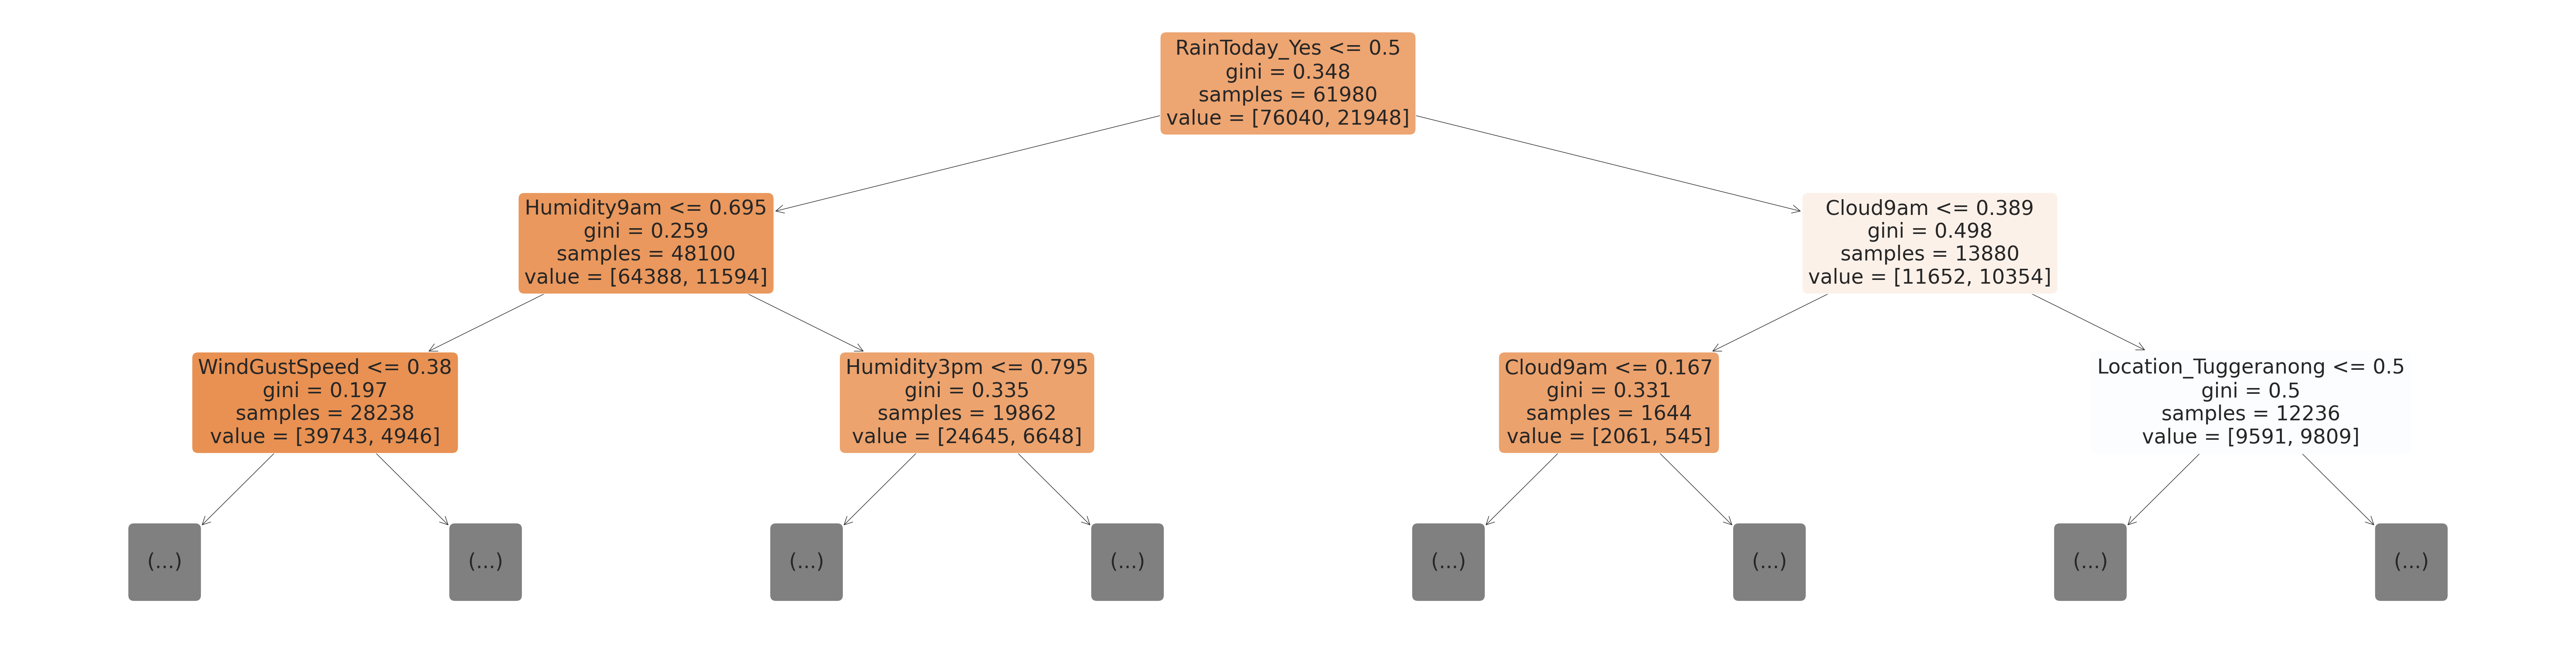

In [194]:
plt.figure(figsize = (80, 20))
plot_tree(model.estimators_[20], max_depth = 2, feature_names = x_train.columns, filled=True, rounded=True)

>**EXERCISE**: Verify that none of the individual decision trees have a better validation accuracy than the random forest.

Just like decision tree, random forests also assign an `importance` to each feature, by combining  the imprtant values from individual trees.

In [195]:
importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importances_
    }).sort_values('importance',ascending=False)

In [196]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.137458
4,Sunshine,0.057349
11,Pressure3pm,0.051851
10,Pressure9am,0.050090
5,WindGustSpeed,0.048827
8,Humidity9am,0.048427
2,Rainfall,0.047859
15,Temp3pm,0.046325
1,MaxTemp,0.042801
0,MinTemp,0.042140


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

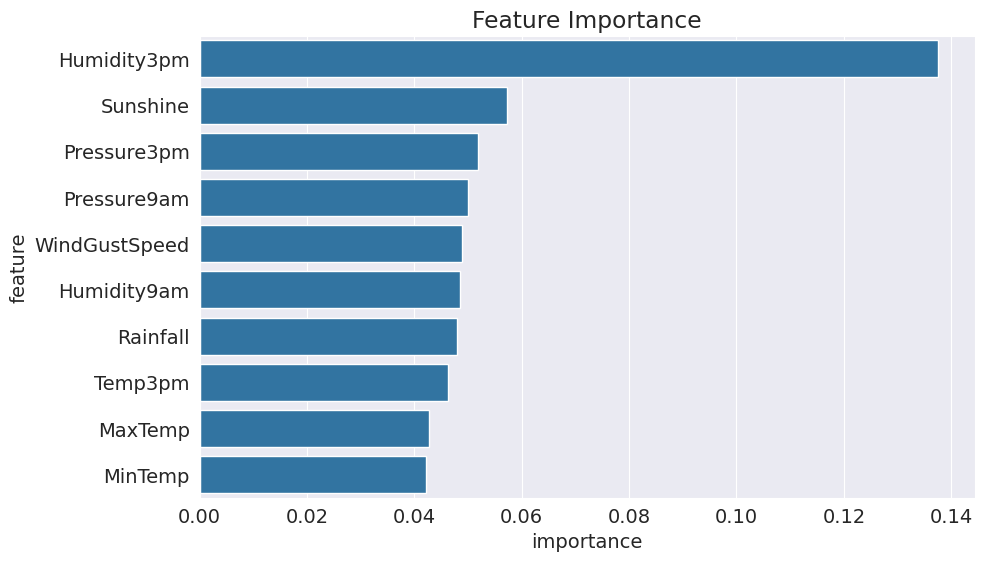

In [197]:
plt.title('Feature Importance')
sns.barplot(data = importance_df.head(10), x='importance', y='feature')

Notice that the dostribution is a lot less skewed than that for a single decision tree.

 # **Hyperparameter Tuning with Random Forests**

 Just like decision trees, random forests also have several hyperparameters. Many of the hyperparameters are applied to to the underlying decision trees.

In [198]:
#?RandomForestClassifier

Let's create a base model with which we can compare models with tuned hyperparameters.

In [199]:
base_model  = RandomForestClassifier(random_state=42, n_jobs = -1).fit(x_train, train_targets)

In [200]:
base_train_acc = base_model.score(x_train, train_targets)
base_val_acc = base_model.score(x_val, val_targets)

In [201]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999795893374699, 0.8563403358885833)

We can use this as a benchmark for hyperparameter tuning.

#`n_estimators`

This argument cotrols the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. **As a general rule, try to have as few etimators as needed.**

*n_estimators does not add complexity to the model but brings more randomness and making the averaging better.*

**10 estimators**

In [202]:
model = RandomForestClassifier(random_state = 42, n_jobs=-1, n_estimators = 10)

In [203]:
model.fit(x_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [204]:
model.score(x_train, train_targets), model.score(x_val, val_targets)

(0.9874168265501898, 0.8450465211539587)

In [205]:
base_accs

(0.9999795893374699, 0.8563403358885833)

**500 estimators**

Try changing it from 100  - default to 200, then 400 , 500 and see the significance in the aaccuracy.

In [206]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)
model.fit(x_train, train_targets)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [207]:
model.score(x_train, train_targets)

0.9999795893374699

In [208]:
model.score(x_val, val_targets)

0.8578617824331441

In [209]:
base_accs

(0.9999795893374699, 0.8563403358885833)

>**EXERCISE:**Vary the value of `n_estimators` and plot the graph between training error and validation error. What is the optimal value of `n_estimators`?

# `max_depth and max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no of leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

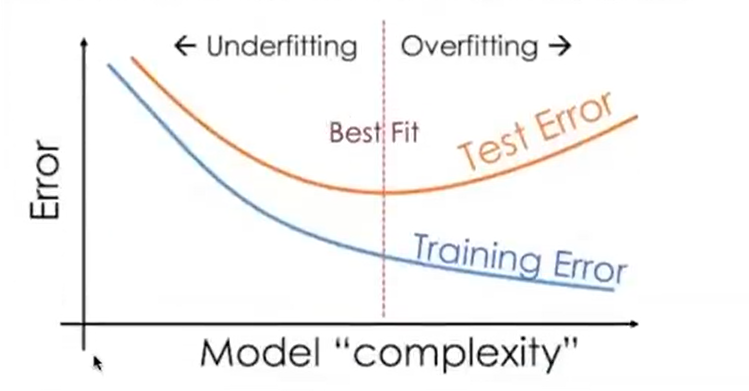

let's define a helper function `test_params` to make it easy to test hyperparameters.

*python function kwargs*

In [210]:
def test_params(**params):
  model  = RandomForestClassifier(random_state  =42, n_jobs=-1,**params).fit(x_train, train_targets)
  return(model.score(x_train, train_targets),model.score(x_val, val_targets))

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [211]:
test_params(max_depth = 5)

(0.8263154672000653, 0.829656504183978)

In [212]:
test_params(max_depth = 26)

(0.9818957423357962, 0.8580373339575166)

In [213]:
test_params(max_leaf_nodes = 2**5)

(0.8334183777605421, 0.8352156357891041)

In [214]:
test_params(max_leaf_nodes = 2**20)

(0.9999795893374699, 0.8575106793843993)

In [215]:
base_accs# no max depth or max leaf nodes

(0.9999795893374699, 0.8563403358885833)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

>**EXERCISE:** Vary the value of `max_depth` and plot the graph between training error and validation error. What is the optimal value of `max_depth`? Do the same for `max_leaf_nodes`.

In [216]:
x_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW',
       'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_nan',
       'RainToday_No', 'RainToday_Yes'],
      dtype='object', length=118)

# `max_features`

Instead of picking all the features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

**max_features: {"auto", sqrt", "log2"}, int or float, default="auto"**
The number of features to consider when looking for the best split:


*   If int, then consider `max_features` features at each split.
*   If float, then `max_features` is a fraction and `round(max_features*n_features)` features are considered at each split.
*   If "auto", then `max_features=sqrt(n_features)`
*   If "sqrt" then `max_features=sqrt(n_features)` (same as "auto").
*   If "log2" then `max_features=log2(n_features)`.
*   If None, , then `max_features=n_features`.

Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than `max_features`.

Notice that the default value `auto` causes only `sqrt(n)` out of total features `(n)` to be chosen randomly at each split. This is the reason each decision tree in the forest is different. Choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well.




Specify that for the first split done, randomly pick **a fraction of the columns**, i.e. randomly pick columns and then try different splits and then select best columns for the split the next time I do a split, randomly select a fraction of columns and based on that perform a split.

Randomly select a fraction of the columns to perform a randomized split for the 2nd decision tree.

 Using a fraction of the colmns to split is better than single splits because the objective is not to **memorize the training set** but to **generalize trends**.


***If you pick too few features, then your model will not be powerful enough i.e.,  because it is not learning its picking a feature and making a split on that feature.***

In [217]:
test_params(max_features = 'log2')

(0.9999795893374699, 0.8571595763356545)

In [218]:
test_params(max_features= 3)

(0.9999795893374699, 0.853472994323834)

In [219]:
test_params(max_features=20)

(0.9999693840062048, 0.8572766106852361)

In [220]:
base_accs

(0.9999795893374699, 0.8563403358885833)

> **EXERCISE:** Find the optimal value of `max_features` for this dataset.

# `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more rows of data. You can increase the values of these of these arguments to change this behaviour and reduce overfitting, especially for very large datasets.

*Example: To reduce complexity of the tree/to regularize, we can say, a node can be split only if if it has `>7 rows`, when a node is split then `2 leaves` are created, so the split is to be performed only when the leaves have a size greater than than `3 rows of data` if the min_samples_leaf is specified.*

A very high value for node size/split size put you in low complexity space while a very low value put you in the high complexity space, then the midpoint is the best.

In [221]:
test_params(min_samples_split = 3, min_samples_leaf= 2)

(0.9615156957994857, 0.8562818187137925)

In [222]:
test_params(min_samples_split = 100, min_samples_leaf = 60)

(0.8520533126505286, 0.8459242787758207)

In [223]:
base_accs

(0.9999795893374699, 0.8563403358885833)

> **EXERCISE:** Find the optimal values of `min_samples_split` and `min_samples_leaf`.

# `mean_impurity_decrease`

This argument is used to control the threshhold for splitting nodes. A node will be split if this split induces a decrease of the impurity(Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.

*When you split and get nodes with no significant reduction in Gini values  i.e. the optimum split leads to small reduction in Gini value, then their is no need to split as it adds unnecessary complexity to the model,
specify that nodes to be split only when the decrease in impurity is higher than a certain value i.e. higher than 0.1.*

By default it is zero


In [224]:
test_params(min_impurity_decrease = 1e-7)

(0.9996632240682533, 0.858505471355843)

In [225]:
test_params(min_impurity_decrease =1e-2)

(0.7775441890843777, 0.7906255485985136)

In [226]:
base_accs

(0.9999795893374699, 0.8563403358885833)

> **EXERCISE:** Find the optimal values of `min_impurity_decrease` for this dataset.

# `bootstrap, max_samples`

By default, a random forest doesn't use the entire dataset for training each tree. Instead it applies a technique called boostrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.

**bootstrap: bool, default, default = True**
*whether bootstrap samples are used when building the trees. If False, the whole datasetis used to build each tree.*

Bootstrapping helps the random forest generalize better, because each decsion tree only sees a fraction of the training set and some rows randomly get higher weightage than others.

Boostrapping works this way: Let's say you have 10 rows, randomly pick rows with replacement where some rows are repeated and some are dropped due to the random seleection a process known as **boostrap**.

By the time you have `10 rows`, some rows rows are repeated while some are dropped.

***Each decision tree is trained on a fraction of the data. Because we pick repeated rows in some decision trees, we assigning a higher weight to certain rows because we are picking them repeatedly and this happens randomly.***

By default bootstrap is set to `True`, and when you set it to `False`, then every decision tree is trained on the entire dataset with one copy for each row.

This system of picking a bootstrap, training a decision tree, picking another bootstrap, training another decision tree is called **bagging** or **bag of bootstraps**.

 You can also control the size of each bootstrap, i.e. out of 10 rows select 7 rows with replacement. This is called **a bag of little bootstraps**

In [227]:
test_params(bootstrap=False)

(0.9999795893374699, 0.8587395400550062)

In [228]:
base_accs

(0.9999795893374699, 0.8563403358885833)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

**max_samples: int or float, default=None**
If boostrap is True, the number of samples to draw from` X` to train each base estimator.


*   If None (default), then draw `X.shape[0]` samplee
*   If  `int`, then draw `max_samples` samples
*   If float, then draw`max_samples*X.shape[0]` samples. Thus `max_samples` should be in the interval `(0,1)`.


*i.e. When bootstraping is true Specify that you only want to pick `90%` of the rows with replacement using bootstrapping technique to reduce overfitting through randomization and improving generalization.*






In [230]:
test_params(max_samples=0.9)

(0.9998265093684942, 0.8569840248112821)

In [231]:
base_accs

(0.9999795893374699, 0.8563403358885833)

If max_split is set to 1 then there is more complexity hence verfitting, if set to 0 then each decision tree is very weak, hence optimum is in between.

# `class_weight`

In [232]:
train_targets.value_counts()/len(train_targets)

RainTomorrow
No     0.777544
Yes    0.222456
Name: count, dtype: float64

You want the decision tree to give a higher weightage i.e. twice as important, you specify a `class_weight` and compare with base which is to give equal weightage to every class/row.

Specify `balanced`, the decision tree figures out on itself.

In [233]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [234]:
test_params(class_weight = 'balanced')

(0.9999591786749398, 0.8558721984902569)

In [235]:
test_params(class_weight={'No':1,'Yes':2})

(0.9999795893374699, 0.8552870267423489)

>**EXERCISE**: Find the optimal value of `class_weight` for this dataset.

# `Putting it together`
Lets train a random forest with customized hyperparameters based on different hyperparams

In [242]:
model = RandomForestClassifier(n_jobs=-1,
                               random_state = 42,
                               n_estimators=500,
                               max_features = 20,
                               max_depth = 30,
                               class_weight = {'No':1,'Yes': 1.5 })

In [243]:
model.fit(x_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=20, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [244]:
model.score(x_train, train_targets), model.score(x_val, val_targets)

(0.9993162428052415, 0.8581543683070981)

In [245]:
base_accs

(0.9999795893374699, 0.8563403358885833)

We've increased the accuracy from `84.5%` with a single decision tree to `85.7%` with a well-tuned random forest. Depending on the dataset and the kind of problem, you may not see a significant improvement with hyperparameter tuning.

This could be due to the following reasons:


*   We may not have found the right mix of hyperparameters to regularize(reduce overfitting) the model properly, and we should keep trying to improve the model.
*   We may have reached the limits of the modelling technique we're currently using(Random Forests), and we should try another modelling technique e.g. gradient boosting.
Decision trees w=suited for non linear taska while Lgistic Regression for linear tasks.
*   We may have reached the limits of what we can predictusing the given amount of data, and we may need more data to improve the model.
*   We may have reached the limits of how well we can predict whether it will rain tomorrow using the gven weather measurements, and we may need more features(columns) to improve the model. We can generate new features using existing features **(feature engineering)**
*  Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which cannot be predicted beyond a certian accuracy with any amount of data for any number of weather measurements with any modelling technique.


**All models are models are wrong, but some are useful and must be utilized to improve business to make them good**




> **EXERCISE:** Experiment with the hyperparameters of the random forest classifier and try to maxmize the validation accuracy.  

Let's compute the accuracy of our model on the test set.

In [246]:
model.score(x_test, test_targets)

0.8475690392843251

Notice the test accuracy is lower,we may have overfitted our choice of hyperparameters to the validation set. The test set tells you not to overoptimize the validation set.

# **Making Predictions on New Inputs**

In [252]:
def predict_input(model, single_input):
  input_df = pd.DataFrame([single_input])
  input_df[numeric_cols]=imputer.transform(input_df[numeric_cols])
  input_df[numeric_cols]=scaler.transform(input_df[numeric_cols])
  input_df[encoded_cols]=encoder.transform(input_df[categorical_cols])
  x_input = input_df[numeric_cols+encoded_cols]
  pred = model.predict(x_input)[0]
  prob = model.predict_proba(x_input)[0][list(model.classes_).index(pred)]
  return pred, prob

In [253]:
new_input  = {'Date': '2021-06-19',
             'Location': 'Albury',
             'MinTemp':23.2,
             'MaxTemp':33.2,
             'Rainfall':10.2,
             'Evaporation':4.2,
             'Sunshine':np.nan,
             'WindGustDir':'NNW',
             'WindGustSpeed':52.0,
             'WindDir9am':'NW',
             'WindDir3pm':'NNE',
             'WindSpeed9am':13.0,
             'WindSpeed3pm':20.0,
             'Humidity9am':89.0,
             'Humidity3pm':58.0,
             'Pressure9am':1004.8,
             'Pressure3pm':1001.5,
             'Cloud9am':8.0,
             'Cloud3pm':5.0,
             'Temp9am':25.7,
             'Temp3pm':33.0,
             'RainToday':'Yes' }

predict_input(model, new_input)

<ipython-input-252-0e6b57d7dd2e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols]=encoder.transform(input_df[categorical_cols])
<ipython-input-252-0e6b57d7dd2e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols]=encoder.transform(input_df[categorical_cols])
<ipython-input-252-0e6b57d7dd2e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

('Yes', 0.8076433670973252)

> **EXERCISE** : Try changing the values in `new_input` and observe how the predictions and probabilities change. Try different values of location, temperature, humidity, pressure. Try to know which columns have the greatest effect on the results.

# **Saving and Loading Trained Models**
Save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Save the model, imputers, scalers, encoders and column names.

We use the `joblib` module to save and load Python objects on the disk.

In [254]:
import joblib

In [255]:
aussie_rain={
    'model': model,
    'imputer':imputer,
    'scaler':scaler,
    'input_cols':input_cols,
    'target_col':target_col,
    'numeric_col':numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols':encoded_cols
}

In [256]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [257]:
aussie_rain2  =joblib.load('aussie_rain.joblib')

**The following topics were covered:**


*   Downloading a real-world dataset
*   Preparing a dataset for training
*   Training and interpreting decision trees
*   Training and interpreting random forests
*   Overfitting hyperparameter tuning and regularization
*   Making predictions on single inputs

**We also introduced the following terms:**


*   Decision tree
*   Random forest
*   Overfitting
*   Hyperparameter tuning
*   Regularization
*   Ensembling
*   Generalization
*   Bootstrapping






